# Object Localization with TensorFlow

The goal of this project is to learn object localization which is a very important use case in Computer vision. Here we will perform simpler form of object localization in which our image will contain 1 emoji located anywhere on the canvas and the goal is to identify the type of emoji as well locate an create bounding box around the emoji


All emojis designed by [OpenMoji](https://openmoji.org/) – the open-source emoji and icon project. License: CC BY-SA 4.0

Use below cell to download the data when running in google colab

In [ ]:
!wget https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip
!mkdir emojis
!unzip -q openmoji-72x72-color.zip -d ./emojis


In [50]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Check if we are using TensorFlow 2.4')
print('Using TensorFlow version', tf.__version__)

Check if we are using TensorFlow 2.4
Using TensorFlow version 2.18.0


# We will use only few emojis from the data around 8 emojis

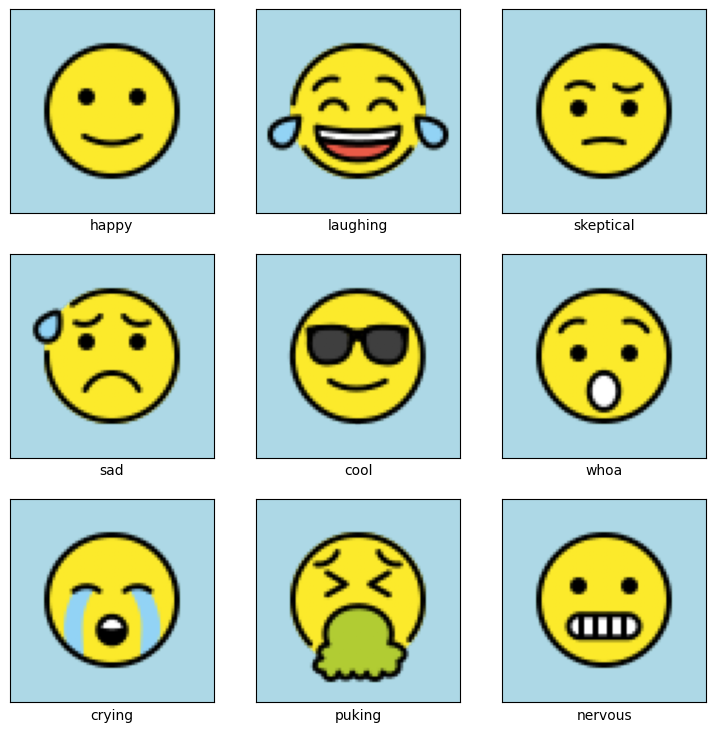

In [51]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    ax = plt.subplot(3, 3, i + 1)
    # To highlight emoji background in transparent and takes subplot background
    ax.set_facecolor('lightblue')
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Task 3: Create Examples

Step 1: Open the image using PIL library
Step 2: Load the image in memory and covert to RGBA i.e. attach an alpha layer that holds transparency detail of each pixel
Step 3: Create new image with white background
step 4: Paste emoji on this white image and maintain pixel transparency of emoji with alpha layer used as mask
step 4: add this new image as new attribute in emoji
Repeat for all 9 image

In [52]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [53]:
emojis

{0: {'name': 'happy',
  'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 1: {'name': 'laughing',
  'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 2: {'name': 'skeptical',
  'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 3: {'name': 'sad',
  'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 4: {'name': 'cool',
  'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 5: {'name': 'whoa',
  'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 6: {'name': 'crying',
  'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 7: {'name': 'puking',
  'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 8: {'name': 'nervous',
  'file': '1F62C.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>}}

# Now we have emoji's above, now what we can do it place those emogis randomly on bigger canvas and train the model. We will create a function that does the same

In [54]:
def create_example():
  class_id = np.random.randint(0,9)
  emoji = np.array(emojis[class_id]['image'])
  images = np.ones((144,144,3)) * 255
  x = np.random.randint(0,72)
  y = np.random.randint(0,72)
  images[x:x+72,y:y+72,:] = emoji
  return images.astype('uint8'), class_id, (x + 10)/144,(y + 10)/144

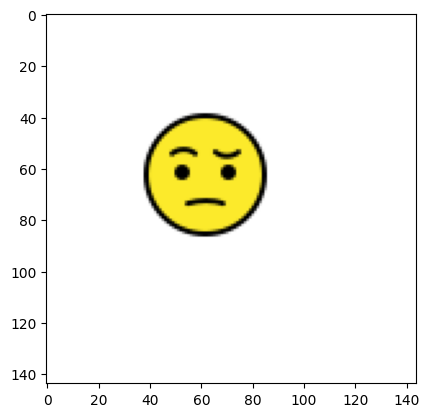

In [55]:
image, class_id , x, y = create_example()
plt.imshow(image)

## Task 4: Plot Bounding Boxes

# To draw the bounding box we will take the help from ImageDraw class of PIL library. It offers different method to draw rect, line, ellipse etc. on an image.

Note ImageDraw need Image (PIL) object to work with so first we will make sure we are having Image object then we need to create ImageDraw object and apply method using the object

In [56]:
def plot_bounding_box(image, true_coordinate, predicted_coordinate=[],norm=False):
  if norm:
    image *= 255.0
    image = image.astype('uint8')
  image =Image.fromarray(image)
  image_draw = ImageDraw.Draw(image)
  x,y = true_coordinate
  x*=144
  y*=144
    #image draw need col1, row1 and col2,row2 format
    # 52 as 10 pixel around emoji is all blank
  image_draw.rectangle((y,x,y+52,x+52),outline='green',width=3)
  if len(predicted_coordinate)==2:
    x,y = predicted_coordinate
    x*=144
    y*=144
    image_draw.rectangle((y,x,y+52,x+52),outline='red',width=3)
  return image


Text(0.5, 1.0, 'skeptical')

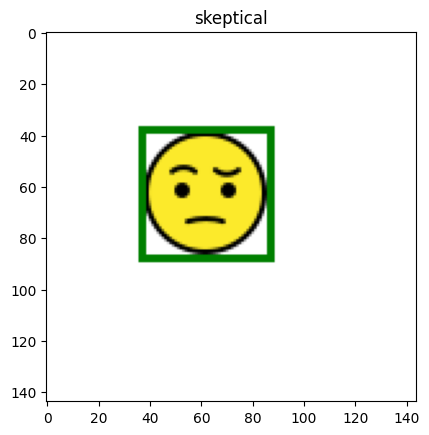

In [57]:
image = plot_bounding_box(image, (x,y))
plt.imshow(image)
plt.title(emojis[class_id]["name"])

## Task 5: Data Generator

# yield: Allows a function to return a value and pause its execution, saving its state. When called again, the function resumes execution right after the yield statement. This makes the function a generator.

In [58]:
def data_generator(batch_size=16):                                         
  while True:
    x_batch = np.zeros((batch_size, 144, 144, 3))                          
    y_batch = np.zeros((batch_size, 9))                                    
    bbox_batch = np.zeros((batch_size, 2))                                

    for i in range(0, batch_size):
      image, class_id, row, col = create_example()                         
      x_batch[i] = image / 255.                                           
      y_batch[i, class_id] = 1.0                                           
      bbox_batch[i] = np.array([row, col])                                 
    yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}

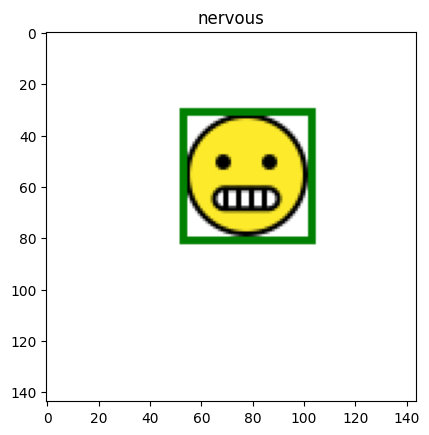

In [59]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]
image = plot_bounding_box(image, coords ,norm=True)
plt.imshow(image)
plt.title(emojis[class_id]["name"])
plt.show()

In [60]:
label['box_out'].shape

(1, 2)

## Task 6: Model

# Now we will create a model. Since our data generator generate input and outputs as dictionary keras requires us to give our input and output layer same name as dictionary so that it can map the input and outputs correctly. This is not required if we are getting input and outputs as a simple standalone value/List

We need to make sure the output are in same sequence as below. This is to to ensure correct loss function is passed for correct output. Ideally this should not be the case as based on dictionary it should work, but seems like some bug in current tensorflow version being used for this project which possibly is using alphabatecial order rather than key for passing loss to output. 

Link highlighting somewhat similar issue:

https://github.com/keras-team/keras/issues/20596

In [61]:
input_ = Input(shape=(144, 144, 3), name='image')              

x = input_

for i in range(0, 5):
  n_filters = 2**(4 + i)                                       
  x = Conv2D(n_filters, 3, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

box_out = Dense(2, name='box_out')(x)                          
class_out = Dense(9, activation='softmax', name='class_out')(x)


model = tf.keras.models.Model(input_, [ box_out, class_out])    
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 144, 144,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 142, 142,  │        448 │ image[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 142, 142,  │         64 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 71, 71,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 69, 69,    │      4,640 │ max_pooling2d_20… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 69, 69,    │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 34, 34,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 14, 14,    │     73,856 │ max_pooling2d_22… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 5, 5, 256) │    295,168 │ max_pooling2d_23… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 256) │      1,024 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 2, 2, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 1024)      │          0 │ max_pooling2d_24… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 659,819 (2.52 MB)

 Trainable params: 658,827 (2.51 MB)

 Non-trainable params: 992 (3.88 KB)

# Intersection Over Union

IOU is an widely used metrics to evaluate the object localization model. It is defined as the ration of common are of two bounding box(actual and predicted)/ combined area of bounding boxes

We will subclass the tf.keras.metrics.Metric class and define update, reset, result method to keep track of our metrics. We will initialize the metrics using self.add_weight() to zero as an state variable. i.e. its value will persists across batches

In [131]:
class IoU(tf.keras.metrics.Metric):
  def __init__(self, **kwargs):
    super(IoU,self).__init__(**kwargs)
    self.iou = self.add_weight(name='iou',initializer='zeros')
    self.total_iou = self.add_weight(name='total_iou',initializer='zeros')
    self.count = self.add_weight(name='count',initializer='zeros')
  def update_state(self, y_true, y_pred,sample_weight=None):
    def get_box(y):                                                
      rows, cols = y[:, 0], y[:, 1]
      rows, cols = rows * 144, cols * 144
      y1, y2 = rows, rows + 52
      x1, x2 = cols, cols + 52
      return tf.cast(x1,tf.float64), tf.cast(y1,tf.float64), tf.cast(x2,tf.float64), tf.cast(y2,tf.float64)
    r1, r2, c1, c2 = get_box(y_true)
    r1_pred, r2_pred, c1_pred, c2_pred = get_box(y_pred)
    int_x1 = tf.cast(tf.math.maximum(c1, c1_pred), tf.float64)
    int_y1 = tf.cast(tf.math.maximum(r1, r1_pred), tf.float64)
    int_x2 = tf.cast(tf.math.minimum(c2, c2_pred), tf.float64)
    int_y2 = tf.cast(tf.math.minimum(r2, r2_pred), tf.float64)
    intersection = tf.math.maximum(tf.constant(0.0, dtype=tf.float64), int_x2 - int_x1) * tf.math.maximum(tf.constant(0.0, dtype=tf.float64), int_y2 - int_y1)
    union = (c2 - c1) * (r2 - r1) + (c2_pred - c1_pred) * (r2_pred - r1_pred) - intersection
    iou = tf.math.divide_no_nan(intersection, union)
    self.count.assign_add(1)
    self.total_iou.assign_add(tf.reduce_mean(iou))
    self.iou.assign(tf.math.divide_no_nan(self.total_iou, self.count))
  def result(self):
    return self.iou
  def reset_state(self):
    self.iou.assign(0.0)
    self.total_iou.assign(0.0)
    self.count.assign(0.0)






In [132]:
model.compile(
    
    loss={
        'class_out': 'categorical_crossentropy',            
        'box_out': 'mse'                                    
    }
    ,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out': 'accuracy',                            
        'box_out': IoU(name='iou')                          
    }
)

## Task 9: Custom Callback: Model Testing

In [133]:
def test_model(model, test_datagen):
  example, label = next(test_datagen)
  x = example['image']
  y_label = label['class_out']
  y_box = label['box_out']
  y_box_pred, y_label_pred  = model.predict(x,verbose=0)
  pred_coord = y_box_pred[0]
  true_coord = y_box[0]
  pred_label = np.argmax(y_label_pred[0])
  image = x[0]
  true_label = emojis[np.argmax(y_label[0])]['name']
  pred_label_name = emojis[pred_label]['name']
  image = plot_bounding_box(image, true_coord, pred_coord, norm = True)
  color = 'green' if true_label == pred_label_name else 'red'
  plt.imshow(image)
  plt.xlabel(f'Pred {pred_label_name}', color = color)
  plt.ylabel(f'True {true_label}', color = color)


In [134]:
def test(model):
  test_datagen = data_generator(1)
  plt.figure(figsize=(16,4))
  for i in range(6):
    plt.subplot(1,6,i+1)
    test_model(model, test_datagen)
  plt.show()

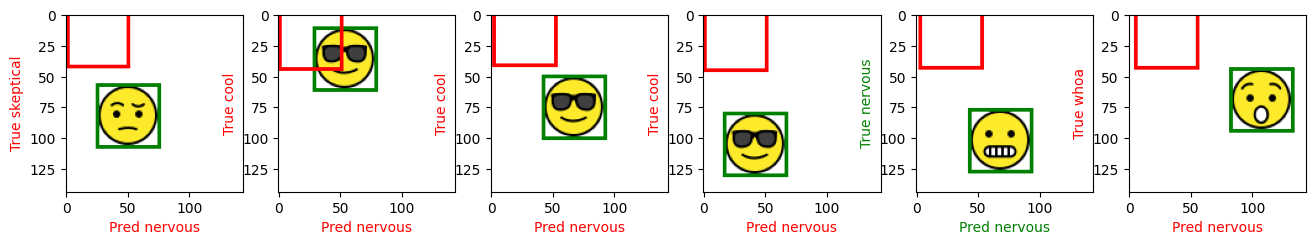

In [135]:
test(model)#model is untrained yet

In [136]:
class imagegenerator(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    test(self.model)

## Task 10: Model Training

Epoch 1/60


C:\Users\rohit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: image. Received: the structure of inputs={'image': '*'}
  warnings.warn(


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - box_out_iou: 0.0262 - box_out_loss: 1.5425 - class_out_accuracy: 0.3272 - class_out_loss: 1.9412 - loss: 3.4838

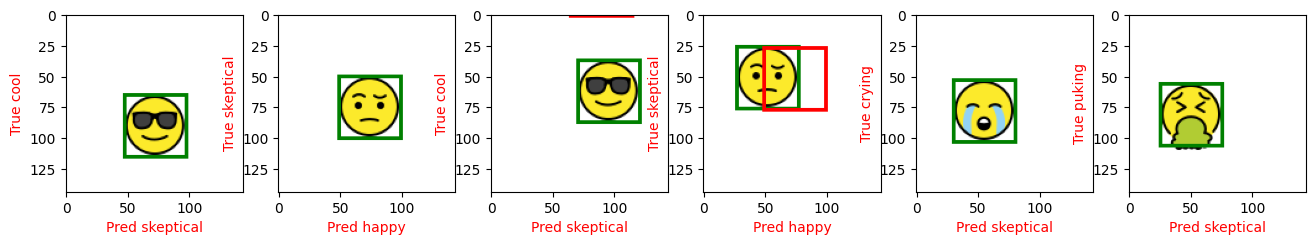

300/300 ━━━━━━━━━━━━━━━━━━━━ 79s 246ms/step - box_out_iou: 0.0263 - box_out_loss: 1.5388 - class_out_accuracy: 0.3281 - class_out_loss: 1.9387 - loss: 3.4775
Epoch 2/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - box_out_iou: 0.0370 - box_out_loss: 0.0696 - class_out_accuracy: 0.9933 - class_out_loss: 0.0501 - loss: 0.1197

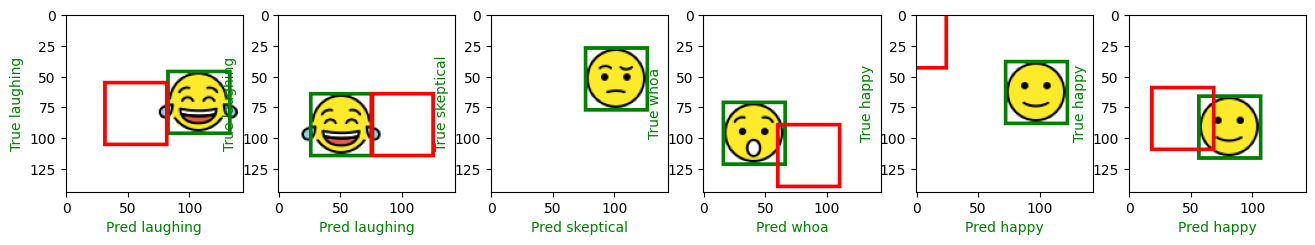

300/300 ━━━━━━━━━━━━━━━━━━━━ 73s 245ms/step - box_out_iou: 0.0370 - box_out_loss: 0.0695 - class_out_accuracy: 0.9933 - class_out_loss: 0.0500 - loss: 0.1196
Epoch 3/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - box_out_iou: 0.0624 - box_out_loss: 0.0376 - class_out_accuracy: 1.0000 - class_out_loss: 0.0085 - loss: 0.0461

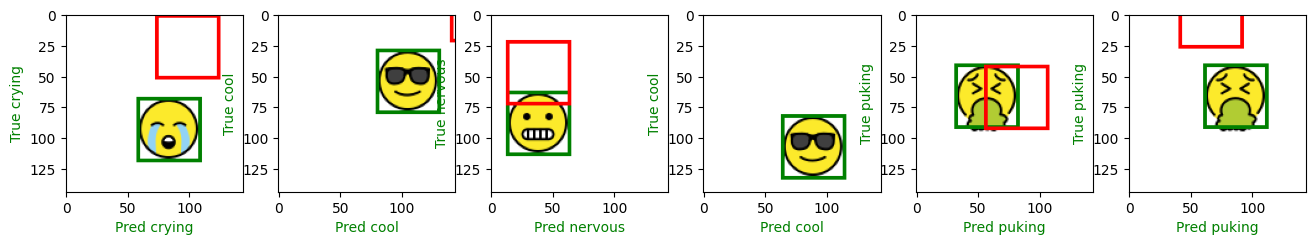

300/300 ━━━━━━━━━━━━━━━━━━━━ 71s 236ms/step - box_out_iou: 0.0624 - box_out_loss: 0.0375 - class_out_accuracy: 1.0000 - class_out_loss: 0.0085 - loss: 0.0461
Epoch 4/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - box_out_iou: 0.0767 - box_out_loss: 0.0218 - class_out_accuracy: 0.9987 - class_out_loss: 0.0065 - loss: 0.0283

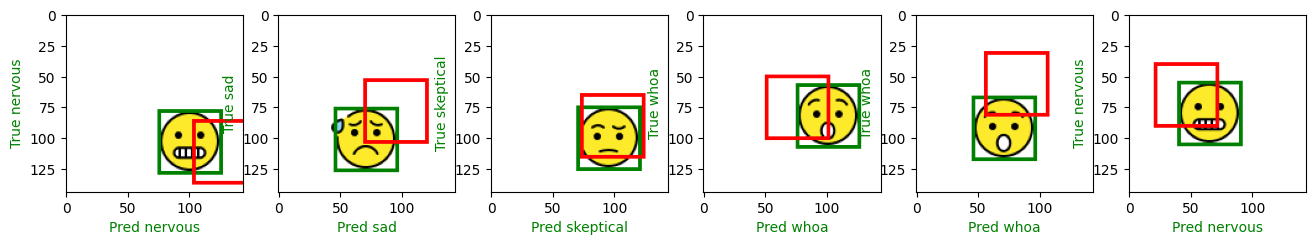

300/300 ━━━━━━━━━━━━━━━━━━━━ 71s 236ms/step - box_out_iou: 0.0767 - box_out_loss: 0.0218 - class_out_accuracy: 0.9987 - class_out_loss: 0.0065 - loss: 0.0283
Epoch 5/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - box_out_iou: 0.0993 - box_out_loss: 0.0131 - class_out_accuracy: 1.0000 - class_out_loss: 0.0025 - loss: 0.0156

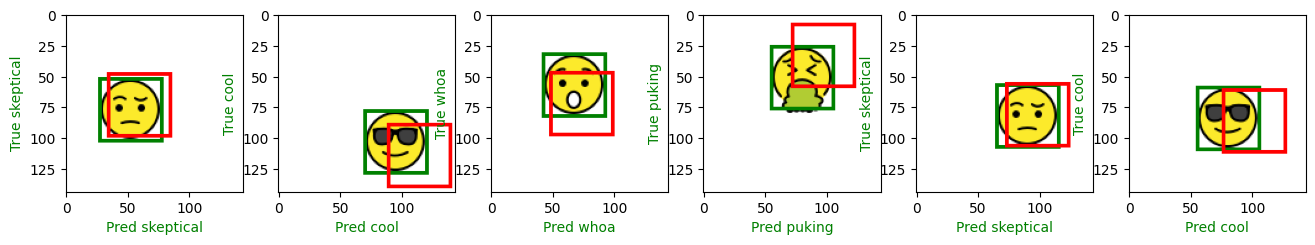

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 229ms/step - box_out_iou: 0.0993 - box_out_loss: 0.0131 - class_out_accuracy: 1.0000 - class_out_loss: 0.0025 - loss: 0.0156
Epoch 6/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - box_out_iou: 0.1142 - box_out_loss: 0.0092 - class_out_accuracy: 1.0000 - class_out_loss: 0.0018 - loss: 0.0110

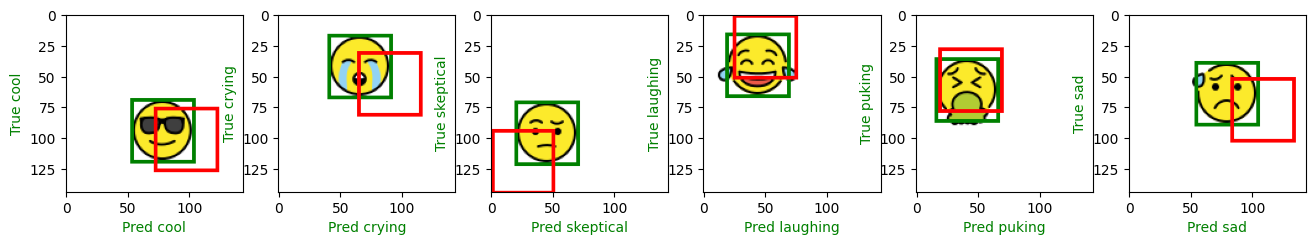

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 230ms/step - box_out_iou: 0.1142 - box_out_loss: 0.0092 - class_out_accuracy: 1.0000 - class_out_loss: 0.0018 - loss: 0.0110
Epoch 7/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - box_out_iou: 0.1212 - box_out_loss: 0.0075 - class_out_accuracy: 1.0000 - class_out_loss: 0.0012 - loss: 0.0088

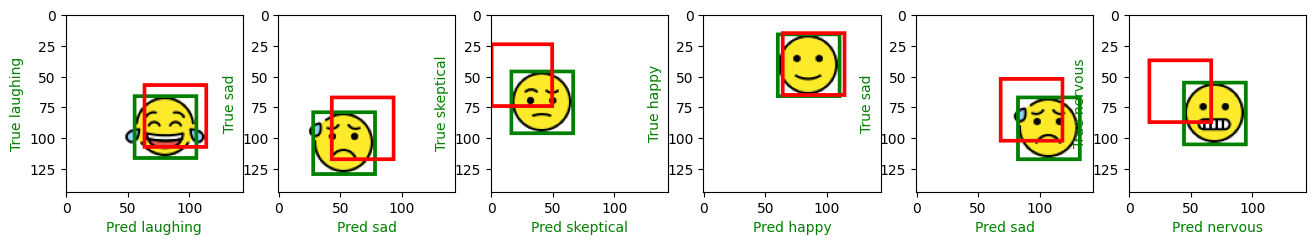

300/300 ━━━━━━━━━━━━━━━━━━━━ 73s 243ms/step - box_out_iou: 0.1212 - box_out_loss: 0.0075 - class_out_accuracy: 1.0000 - class_out_loss: 0.0012 - loss: 0.0088
Epoch 8/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - box_out_iou: 0.1340 - box_out_loss: 0.0060 - class_out_accuracy: 1.0000 - class_out_loss: 8.9788e-04 - loss: 0.0069

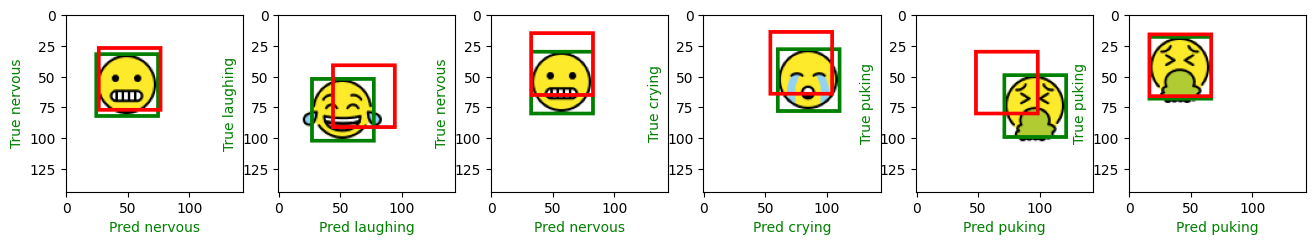

300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 240ms/step - box_out_iou: 0.1340 - box_out_loss: 0.0060 - class_out_accuracy: 1.0000 - class_out_loss: 8.9796e-04 - loss: 0.0069
Epoch 9/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - box_out_iou: 0.1587 - box_out_loss: 0.0044 - class_out_accuracy: 1.0000 - class_out_loss: 5.4774e-04 - loss: 0.0050

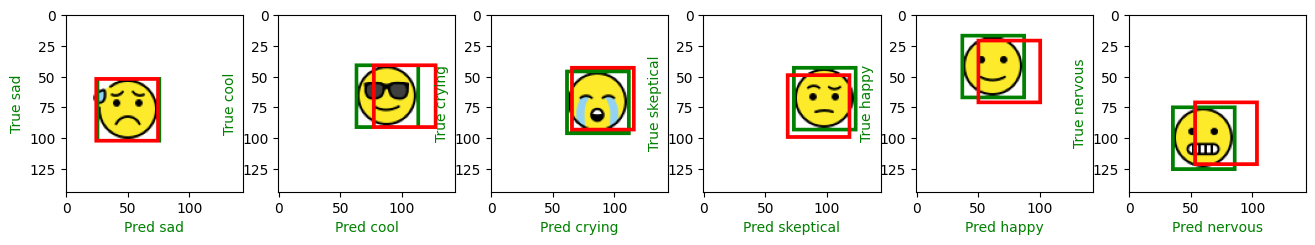

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - box_out_iou: 0.1587 - box_out_loss: 0.0044 - class_out_accuracy: 1.0000 - class_out_loss: 5.4785e-04 - loss: 0.0050
Epoch 10/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - box_out_iou: 0.1572 - box_out_loss: 0.0038 - class_out_accuracy: 1.0000 - class_out_loss: 5.4915e-04 - loss: 0.0044

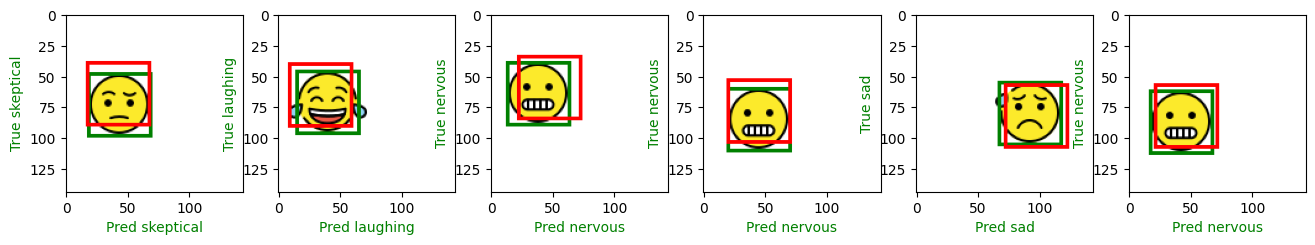

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - box_out_iou: 0.1572 - box_out_loss: 0.0038 - class_out_accuracy: 1.0000 - class_out_loss: 5.4903e-04 - loss: 0.0044
Epoch 11/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - box_out_iou: 0.1727 - box_out_loss: 0.0029 - class_out_accuracy: 1.0000 - class_out_loss: 3.8693e-04 - loss: 0.0033

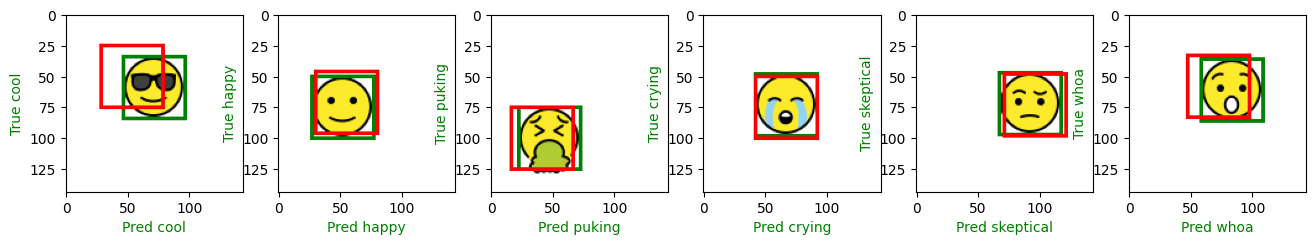

300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 239ms/step - box_out_iou: 0.1727 - box_out_loss: 0.0029 - class_out_accuracy: 1.0000 - class_out_loss: 3.8694e-04 - loss: 0.0033
Epoch 12/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - box_out_iou: 0.1915 - box_out_loss: 0.0025 - class_out_accuracy: 1.0000 - class_out_loss: 3.5853e-04 - loss: 0.0028

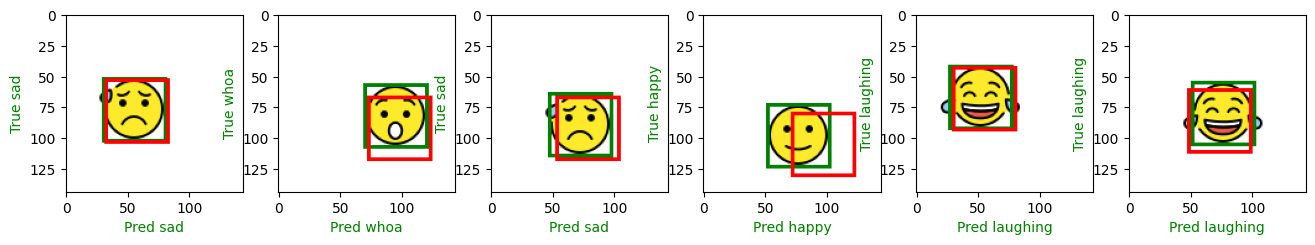

300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 241ms/step - box_out_iou: 0.1915 - box_out_loss: 0.0025 - class_out_accuracy: 1.0000 - class_out_loss: 3.5843e-04 - loss: 0.0028
Epoch 13/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - box_out_iou: 0.2099 - box_out_loss: 0.0020 - class_out_accuracy: 1.0000 - class_out_loss: 2.8761e-04 - loss: 0.0023

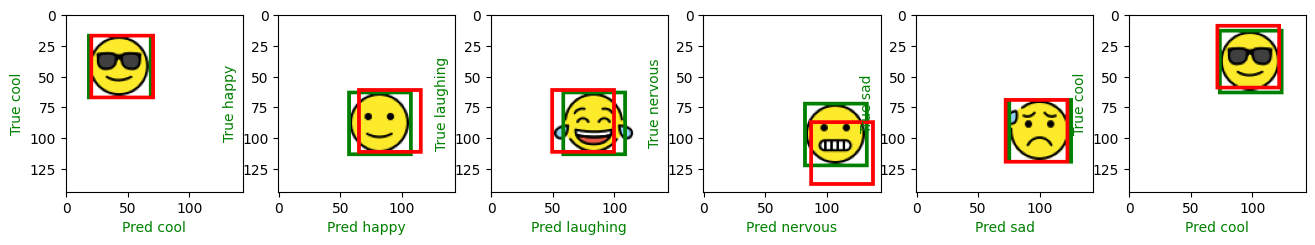

300/300 ━━━━━━━━━━━━━━━━━━━━ 75s 250ms/step - box_out_iou: 0.2099 - box_out_loss: 0.0020 - class_out_accuracy: 1.0000 - class_out_loss: 2.8753e-04 - loss: 0.0023
Epoch 14/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - box_out_iou: 0.2089 - box_out_loss: 0.0017 - class_out_accuracy: 1.0000 - class_out_loss: 2.0452e-04 - loss: 0.0019

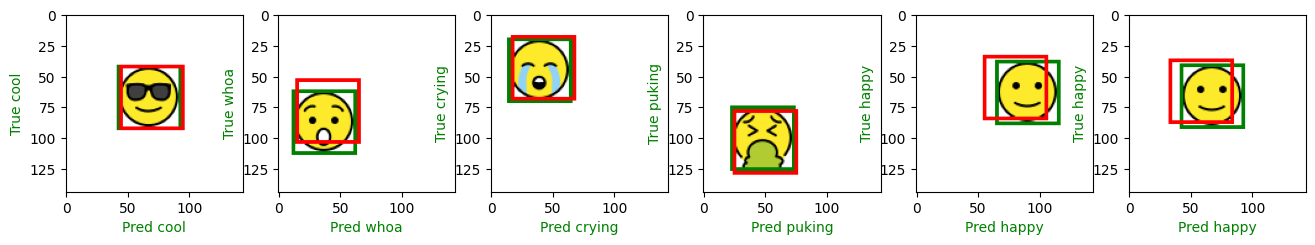

300/300 ━━━━━━━━━━━━━━━━━━━━ 73s 245ms/step - box_out_iou: 0.2089 - box_out_loss: 0.0017 - class_out_accuracy: 1.0000 - class_out_loss: 2.0448e-04 - loss: 0.0019
Epoch 15/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - box_out_iou: 0.2146 - box_out_loss: 0.0017 - class_out_accuracy: 1.0000 - class_out_loss: 1.7176e-04 - loss: 0.0018

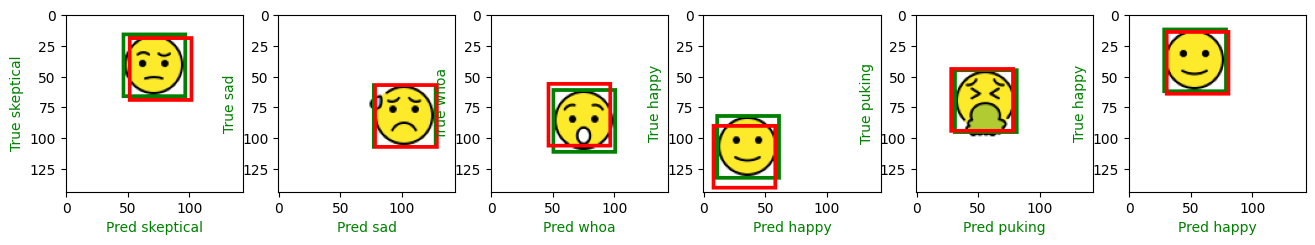

300/300 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - box_out_iou: 0.2146 - box_out_loss: 0.0017 - class_out_accuracy: 1.0000 - class_out_loss: 1.7177e-04 - loss: 0.0018
Epoch 16/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - box_out_iou: 0.2344 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - class_out_loss: 1.7466e-04 - loss: 0.0014

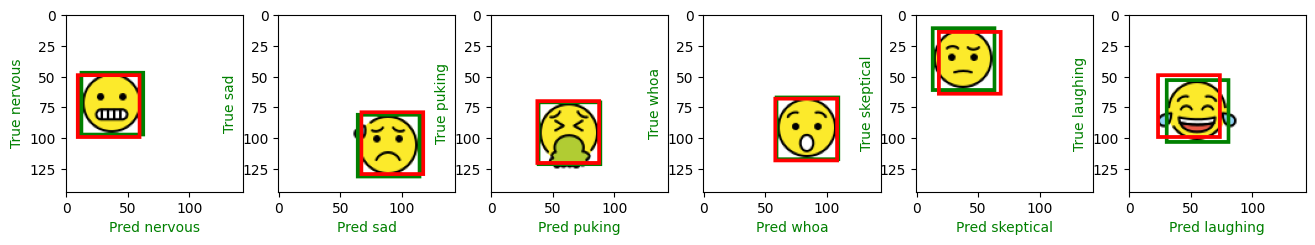

300/300 ━━━━━━━━━━━━━━━━━━━━ 73s 243ms/step - box_out_iou: 0.2345 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - class_out_loss: 1.7460e-04 - loss: 0.0014
Epoch 17/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - box_out_iou: 0.2392 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - class_out_loss: 2.4073e-04 - loss: 0.0013

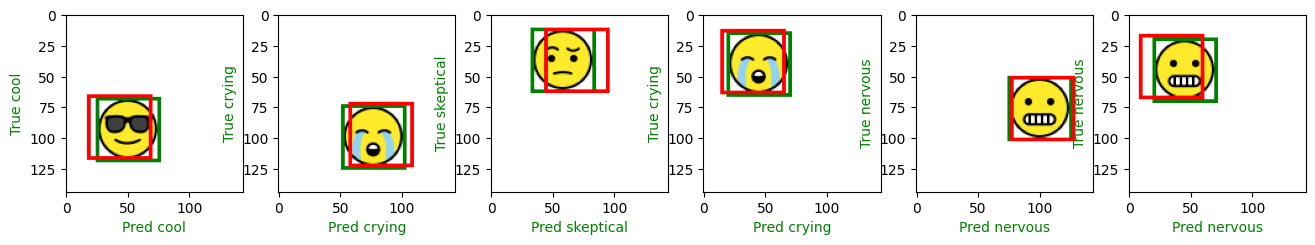

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - box_out_iou: 0.2392 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - class_out_loss: 2.4045e-04 - loss: 0.0013
Epoch 18/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - box_out_iou: 0.2241 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - class_out_loss: 2.6028e-04 - loss: 0.0016

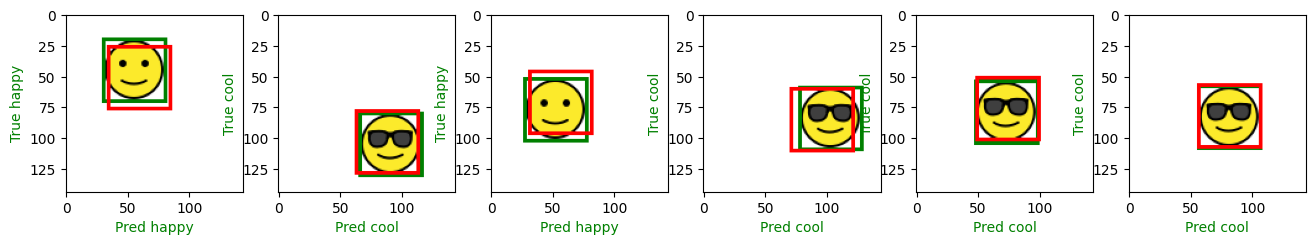

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 229ms/step - box_out_iou: 0.2241 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - class_out_loss: 2.6011e-04 - loss: 0.0016
Epoch 19/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - box_out_iou: 0.2482 - box_out_loss: 0.0034 - class_out_accuracy: 0.9976 - class_out_loss: 0.0115 - loss: 0.0149

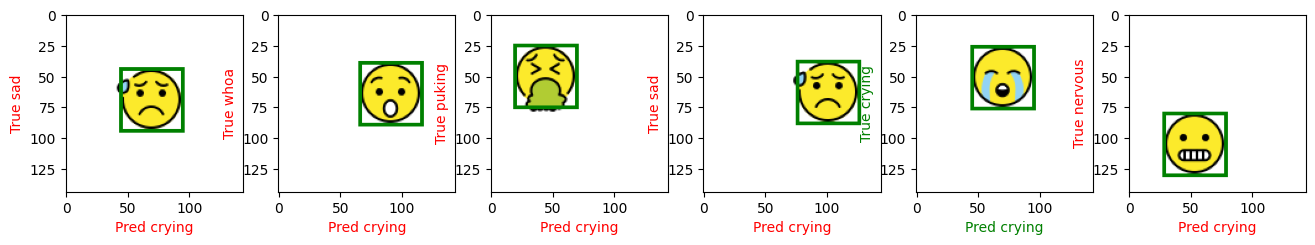

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - box_out_iou: 0.2482 - box_out_loss: 0.0037 - class_out_accuracy: 0.9975 - class_out_loss: 0.0120 - loss: 0.0157
Epoch 20/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - box_out_iou: 0.0703 - box_out_loss: 0.0823 - class_out_accuracy: 0.9034 - class_out_loss: 0.2882 - loss: 0.3705

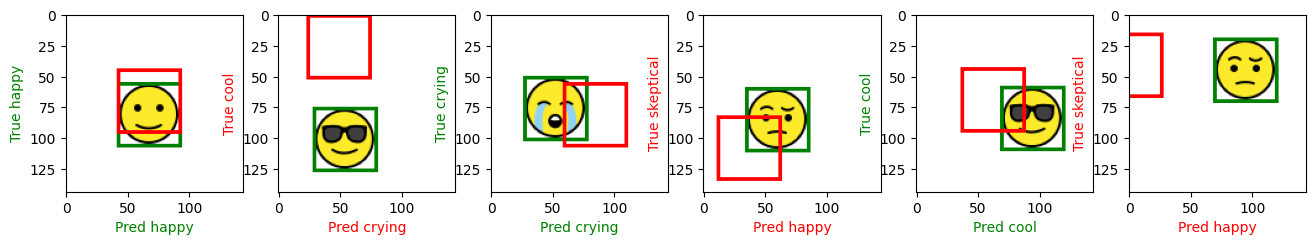

300/300 ━━━━━━━━━━━━━━━━━━━━ 73s 244ms/step - box_out_iou: 0.0704 - box_out_loss: 0.0821 - class_out_accuracy: 0.9036 - class_out_loss: 0.2876 - loss: 0.3698
Epoch 21/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - box_out_iou: 0.1655 - box_out_loss: 0.0037 - class_out_accuracy: 0.9982 - class_out_loss: 0.0061 - loss: 0.0099

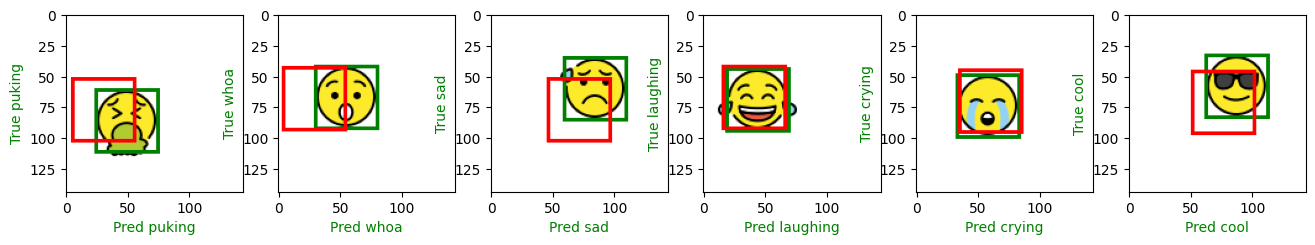

300/300 ━━━━━━━━━━━━━━━━━━━━ 78s 261ms/step - box_out_iou: 0.1655 - box_out_loss: 0.0037 - class_out_accuracy: 0.9982 - class_out_loss: 0.0061 - loss: 0.0099
Epoch 22/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - box_out_iou: 0.2045 - box_out_loss: 0.0021 - class_out_accuracy: 1.0000 - class_out_loss: 5.0840e-04 - loss: 0.0026

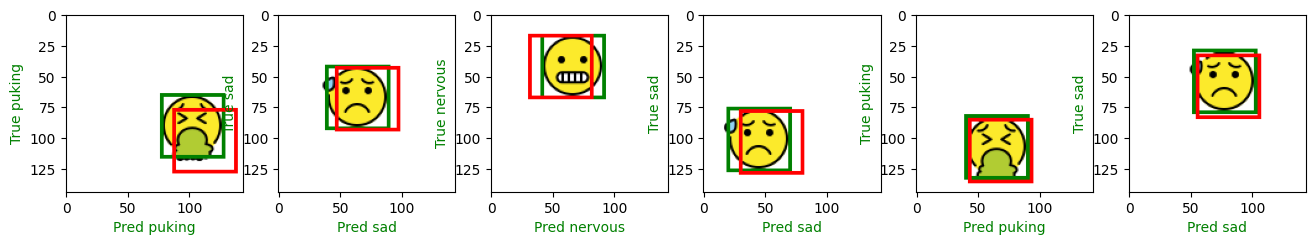

300/300 ━━━━━━━━━━━━━━━━━━━━ 74s 248ms/step - box_out_iou: 0.2045 - box_out_loss: 0.0021 - class_out_accuracy: 1.0000 - class_out_loss: 5.0851e-04 - loss: 0.0026
Epoch 23/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - box_out_iou: 0.2204 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - class_out_loss: 3.7418e-04 - loss: 0.0020

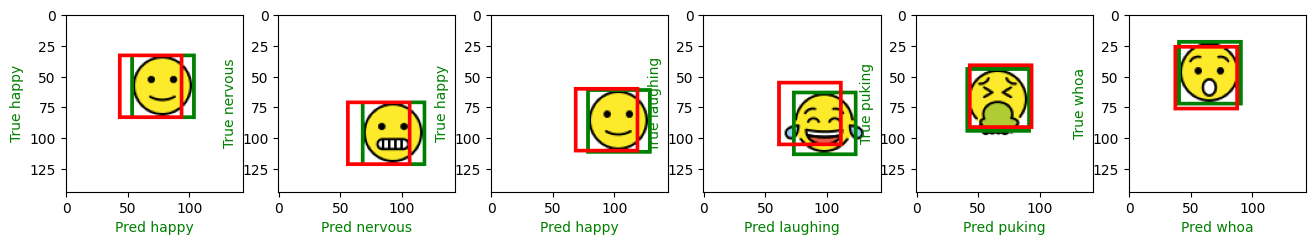

300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 239ms/step - box_out_iou: 0.2204 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - class_out_loss: 3.7459e-04 - loss: 0.0020
Epoch 24/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - box_out_iou: 0.2187 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - class_out_loss: 2.3368e-04 - loss: 0.0019

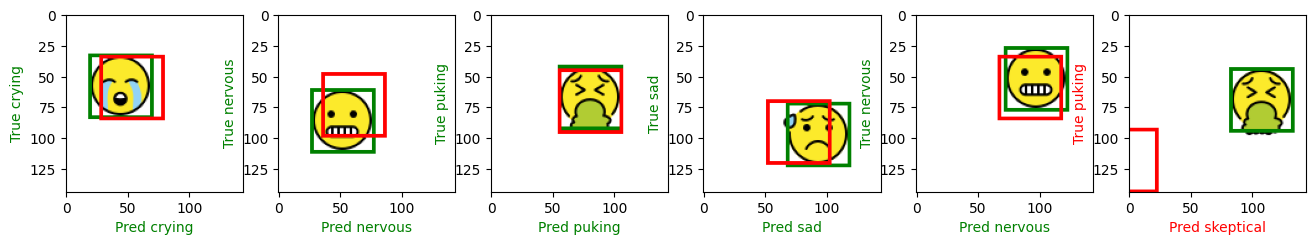

300/300 ━━━━━━━━━━━━━━━━━━━━ 97s 324ms/step - box_out_iou: 0.2187 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - class_out_loss: 2.3371e-04 - loss: 0.0018
Epoch 25/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - box_out_iou: 0.2351 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - class_out_loss: 1.6650e-04 - loss: 0.0013

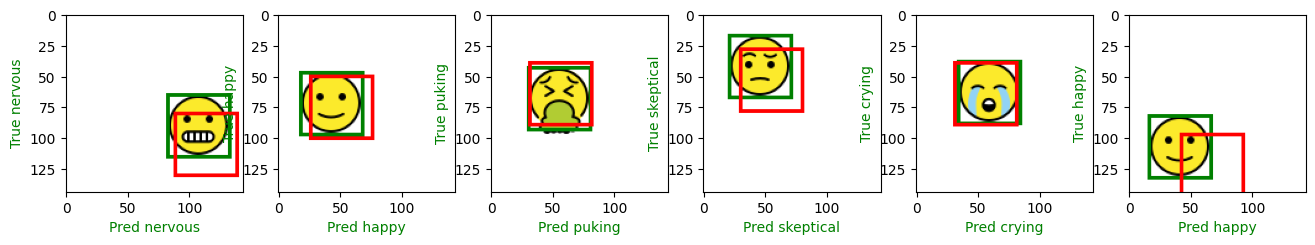

300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 255ms/step - box_out_iou: 0.2351 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - class_out_loss: 1.6654e-04 - loss: 0.0013
Epoch 26/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - box_out_iou: 0.2237 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - class_out_loss: 2.3368e-04 - loss: 0.0014

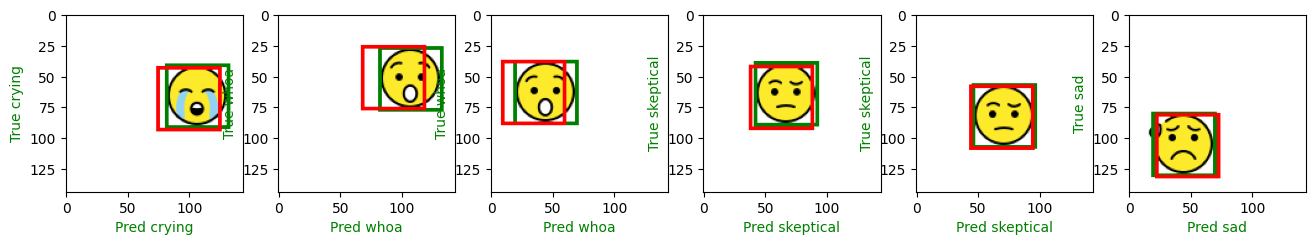

300/300 ━━━━━━━━━━━━━━━━━━━━ 71s 236ms/step - box_out_iou: 0.2238 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - class_out_loss: 2.3347e-04 - loss: 0.0014
Epoch 27/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - box_out_iou: 0.2375 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - class_out_loss: 2.5000e-04 - loss: 0.0013

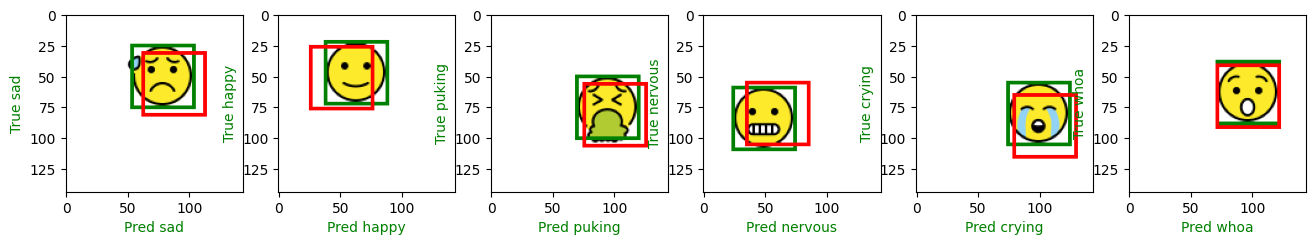

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 233ms/step - box_out_iou: 0.2375 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - class_out_loss: 2.5001e-04 - loss: 0.0013
Epoch 28/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - box_out_iou: 0.2530 - box_out_loss: 8.5383e-04 - class_out_accuracy: 1.0000 - class_out_loss: 1.0924e-04 - loss: 9.6307e-04

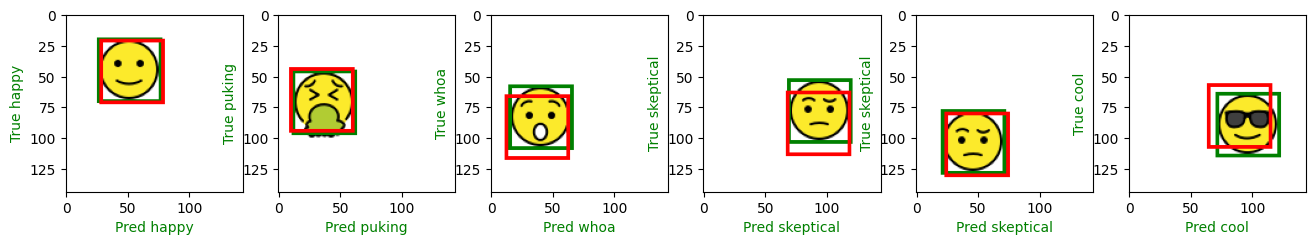

300/300 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - box_out_iou: 0.2529 - box_out_loss: 8.5388e-04 - class_out_accuracy: 1.0000 - class_out_loss: 1.0919e-04 - loss: 9.6307e-04
Epoch 29/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - box_out_iou: 0.2543 - box_out_loss: 8.1652e-04 - class_out_accuracy: 1.0000 - class_out_loss: 6.6719e-05 - loss: 8.8324e-04

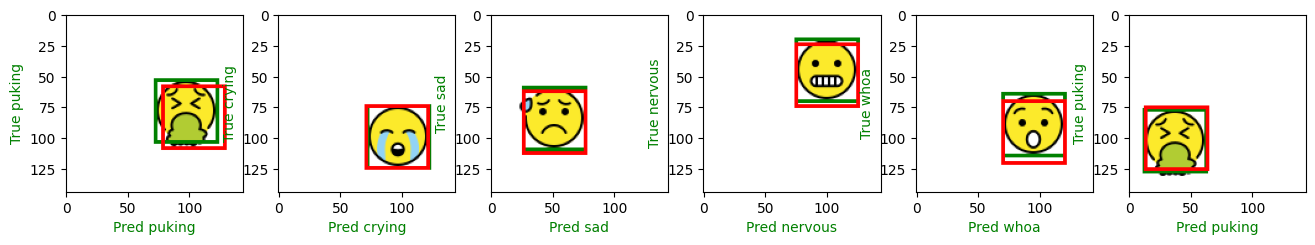

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 233ms/step - box_out_iou: 0.2543 - box_out_loss: 8.1637e-04 - class_out_accuracy: 1.0000 - class_out_loss: 6.6718e-05 - loss: 8.8308e-04
Epoch 30/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - box_out_iou: 0.2670 - box_out_loss: 7.5196e-04 - class_out_accuracy: 1.0000 - class_out_loss: 8.8722e-05 - loss: 8.4069e-04

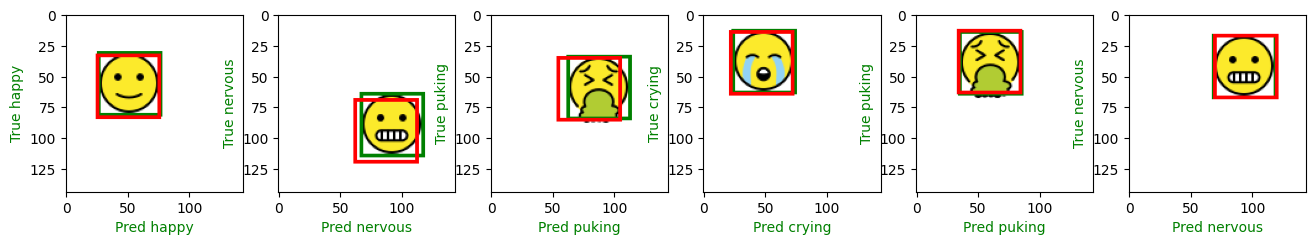

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 230ms/step - box_out_iou: 0.2670 - box_out_loss: 7.5198e-04 - class_out_accuracy: 1.0000 - class_out_loss: 8.8777e-05 - loss: 8.4076e-04
Epoch 31/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - box_out_iou: 0.2502 - box_out_loss: 7.9055e-04 - class_out_accuracy: 1.0000 - class_out_loss: 1.0316e-04 - loss: 8.9370e-04

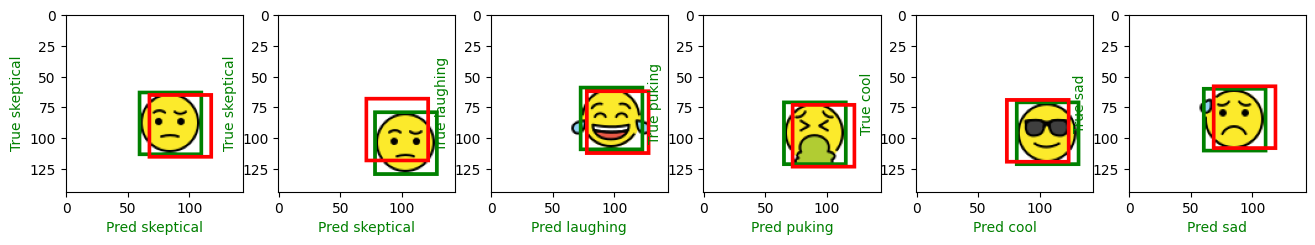

300/300 ━━━━━━━━━━━━━━━━━━━━ 68s 228ms/step - box_out_iou: 0.2502 - box_out_loss: 7.9035e-04 - class_out_accuracy: 1.0000 - class_out_loss: 1.0313e-04 - loss: 8.9348e-04
Epoch 32/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - box_out_iou: 0.2538 - box_out_loss: 8.2455e-04 - class_out_accuracy: 1.0000 - class_out_loss: 7.6732e-05 - loss: 9.0128e-04

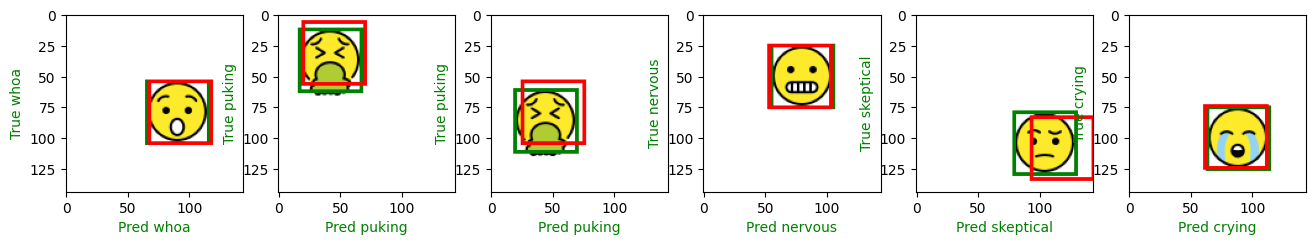

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 229ms/step - box_out_iou: 0.2538 - box_out_loss: 8.2423e-04 - class_out_accuracy: 1.0000 - class_out_loss: 7.6759e-05 - loss: 9.0099e-04
Epoch 33/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - box_out_iou: 0.2570 - box_out_loss: 6.4008e-04 - class_out_accuracy: 1.0000 - class_out_loss: 6.1276e-05 - loss: 7.0136e-04

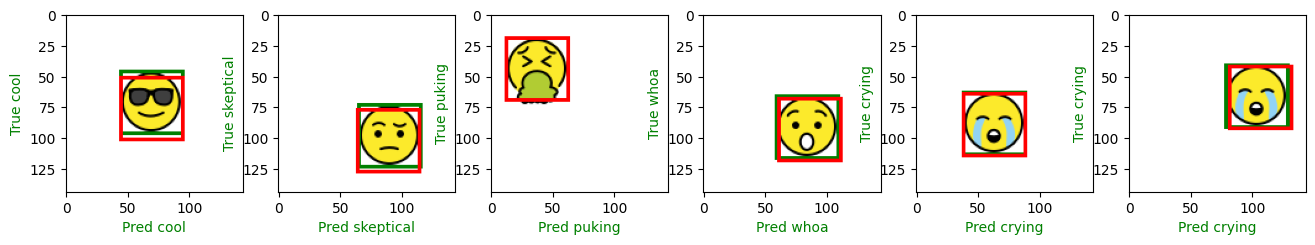

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - box_out_iou: 0.2570 - box_out_loss: 6.4011e-04 - class_out_accuracy: 1.0000 - class_out_loss: 6.1282e-05 - loss: 7.0139e-04
Epoch 34/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - box_out_iou: 0.2795 - box_out_loss: 5.1430e-04 - class_out_accuracy: 1.0000 - class_out_loss: 5.2280e-05 - loss: 5.6658e-04

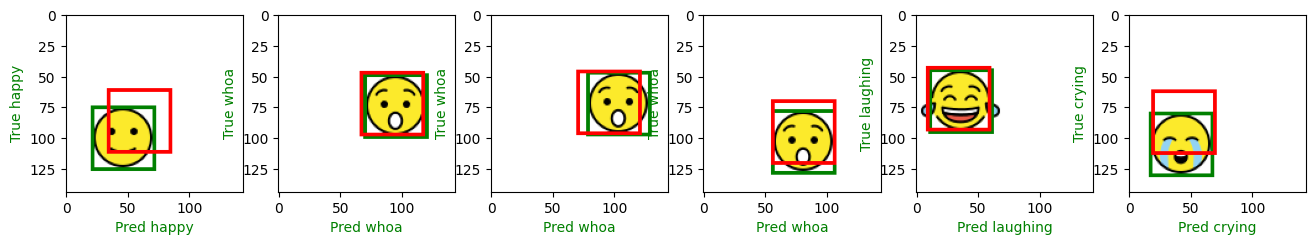

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 233ms/step - box_out_iou: 0.2795 - box_out_loss: 5.1470e-04 - class_out_accuracy: 1.0000 - class_out_loss: 5.2354e-05 - loss: 5.6705e-04
Epoch 35/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - box_out_iou: 0.2730 - box_out_loss: 6.8820e-04 - class_out_accuracy: 1.0000 - class_out_loss: 7.6283e-05 - loss: 7.6448e-04

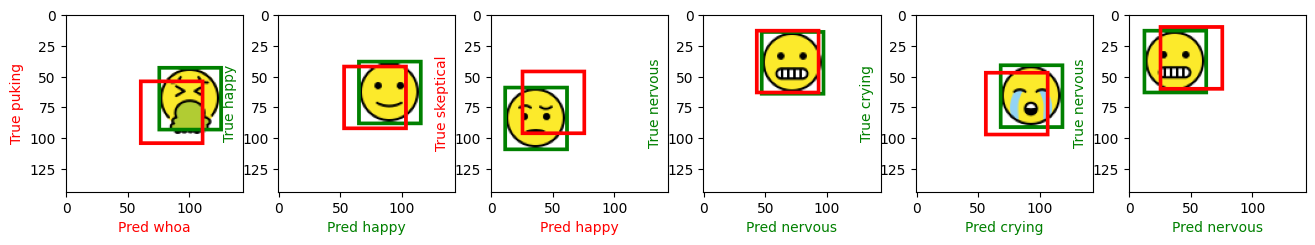

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - box_out_iou: 0.2730 - box_out_loss: 6.8805e-04 - class_out_accuracy: 1.0000 - class_out_loss: 7.6289e-05 - loss: 7.6434e-04
Epoch 36/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - box_out_iou: 0.2200 - box_out_loss: 0.0131 - class_out_accuracy: 0.9798 - class_out_loss: 0.0983 - loss: 0.1115

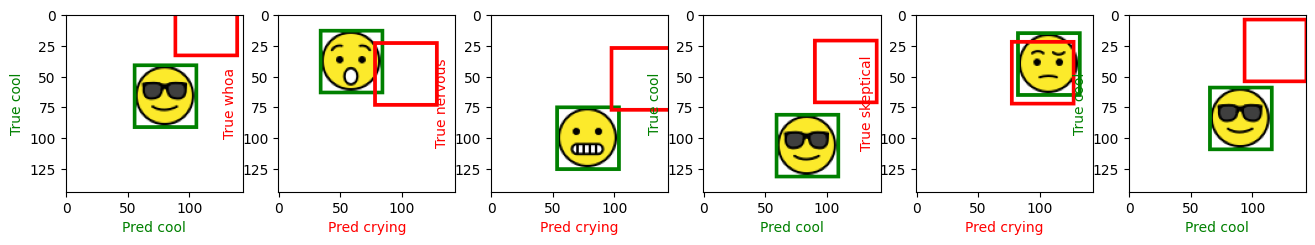

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - box_out_iou: 0.2198 - box_out_loss: 0.0132 - class_out_accuracy: 0.9798 - class_out_loss: 0.0985 - loss: 0.1117
Epoch 37/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - box_out_iou: 0.1468 - box_out_loss: 0.0055 - class_out_accuracy: 0.9948 - class_out_loss: 0.0184 - loss: 0.0239

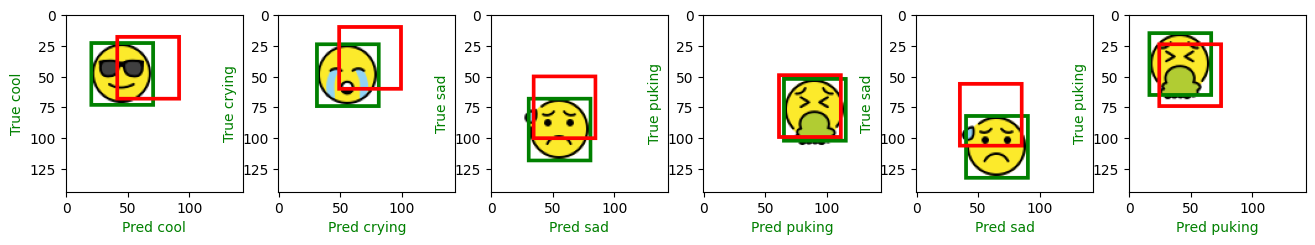

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - box_out_iou: 0.1468 - box_out_loss: 0.0055 - class_out_accuracy: 0.9948 - class_out_loss: 0.0184 - loss: 0.0239
Epoch 38/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - box_out_iou: 0.1780 - box_out_loss: 0.0030 - class_out_accuracy: 0.9967 - class_out_loss: 0.0063 - loss: 0.0093

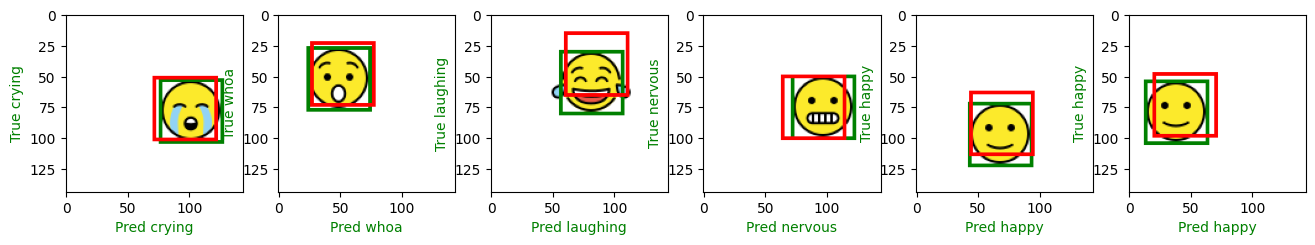

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - box_out_iou: 0.1780 - box_out_loss: 0.0030 - class_out_accuracy: 0.9967 - class_out_loss: 0.0063 - loss: 0.0093
Epoch 39/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - box_out_iou: 0.1975 - box_out_loss: 0.0026 - class_out_accuracy: 0.9994 - class_out_loss: 0.0021 - loss: 0.0047

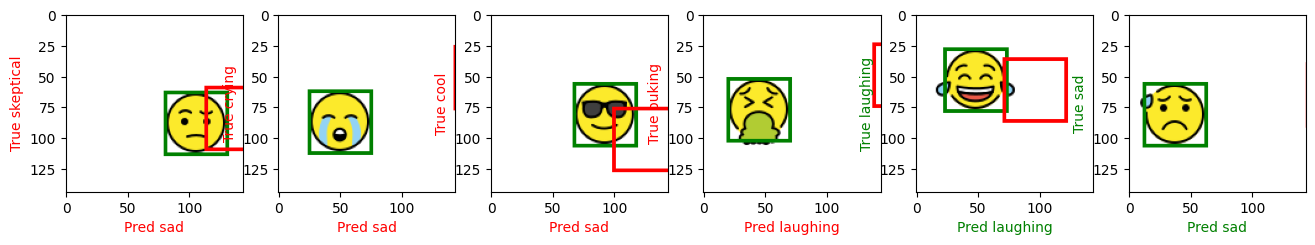

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - box_out_iou: 0.1975 - box_out_loss: 0.0026 - class_out_accuracy: 0.9994 - class_out_loss: 0.0021 - loss: 0.0047
Epoch 40/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - box_out_iou: 0.2212 - box_out_loss: 0.0017 - class_out_accuracy: 0.9994 - class_out_loss: 0.0014 - loss: 0.0031

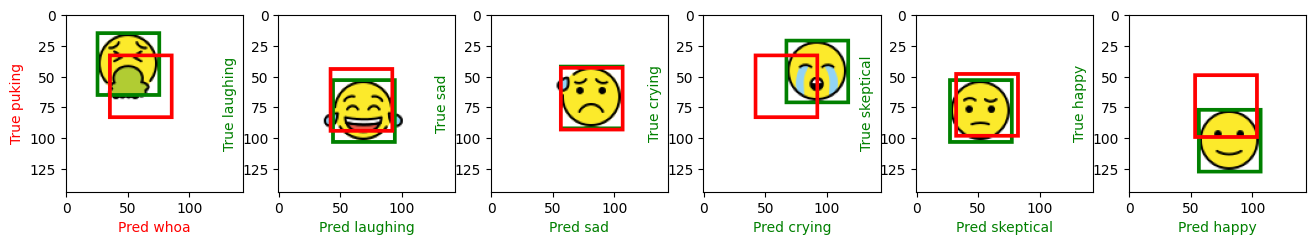

300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 239ms/step - box_out_iou: 0.2212 - box_out_loss: 0.0017 - class_out_accuracy: 0.9994 - class_out_loss: 0.0014 - loss: 0.0031
Epoch 41/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - box_out_iou: 0.1949 - box_out_loss: 0.0017 - class_out_accuracy: 0.9998 - class_out_loss: 5.7762e-04 - loss: 0.0023

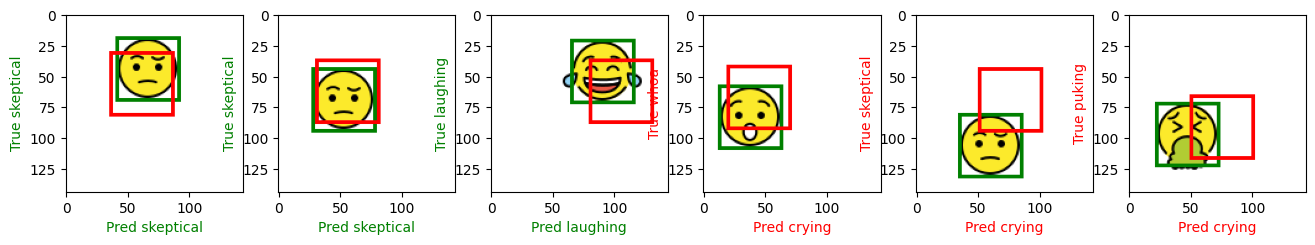

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - box_out_iou: 0.1950 - box_out_loss: 0.0017 - class_out_accuracy: 0.9998 - class_out_loss: 5.8362e-04 - loss: 0.0023
Epoch 42/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - box_out_iou: 0.1567 - box_out_loss: 0.0055 - class_out_accuracy: 0.9970 - class_out_loss: 0.0053 - loss: 0.0108

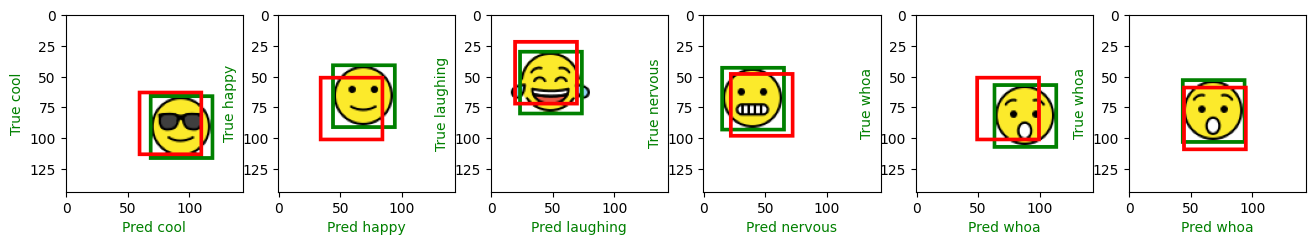

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 234ms/step - box_out_iou: 0.1567 - box_out_loss: 0.0055 - class_out_accuracy: 0.9971 - class_out_loss: 0.0053 - loss: 0.0107
Epoch 43/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - box_out_iou: 0.2148 - box_out_loss: 0.0019 - class_out_accuracy: 0.9991 - class_out_loss: 0.0022 - loss: 0.0041

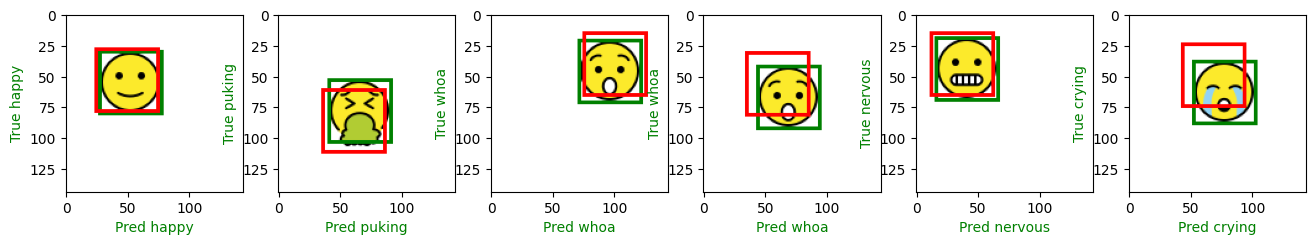

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 229ms/step - box_out_iou: 0.2148 - box_out_loss: 0.0019 - class_out_accuracy: 0.9991 - class_out_loss: 0.0022 - loss: 0.0041
Epoch 44/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - box_out_iou: 0.1901 - box_out_loss: 0.0026 - class_out_accuracy: 0.9959 - class_out_loss: 0.0151 - loss: 0.0176

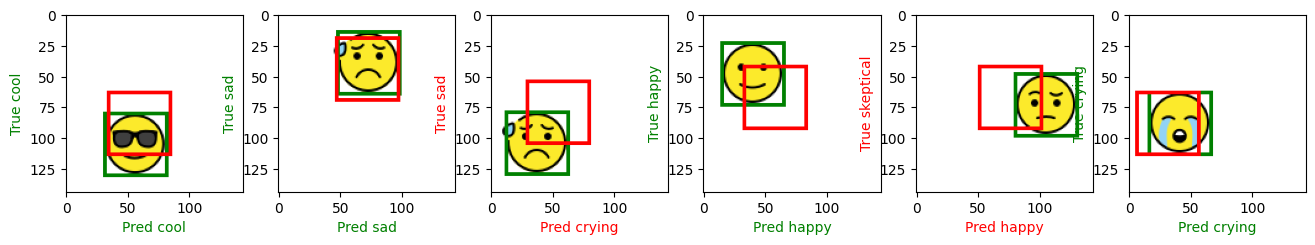

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 230ms/step - box_out_iou: 0.1900 - box_out_loss: 0.0026 - class_out_accuracy: 0.9958 - class_out_loss: 0.0151 - loss: 0.0177
Epoch 45/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - box_out_iou: 0.1868 - box_out_loss: 0.0029 - class_out_accuracy: 0.9997 - class_out_loss: 8.0153e-04 - loss: 0.0037

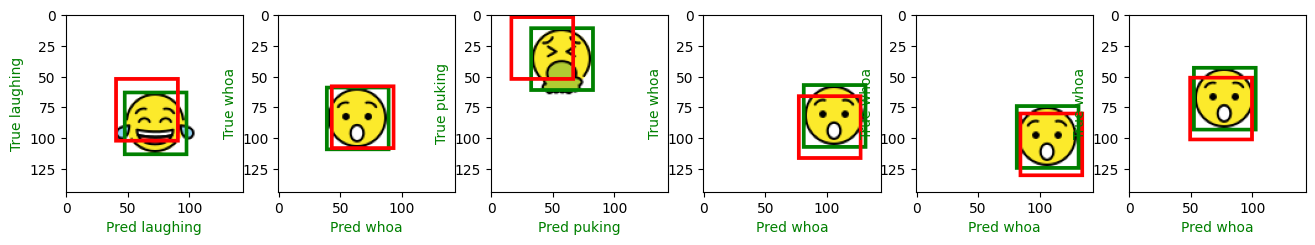

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 234ms/step - box_out_iou: 0.1867 - box_out_loss: 0.0029 - class_out_accuracy: 0.9997 - class_out_loss: 8.1118e-04 - loss: 0.0037
Epoch 46/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - box_out_iou: 0.1818 - box_out_loss: 0.0034 - class_out_accuracy: 0.9990 - class_out_loss: 0.0033 - loss: 0.0067

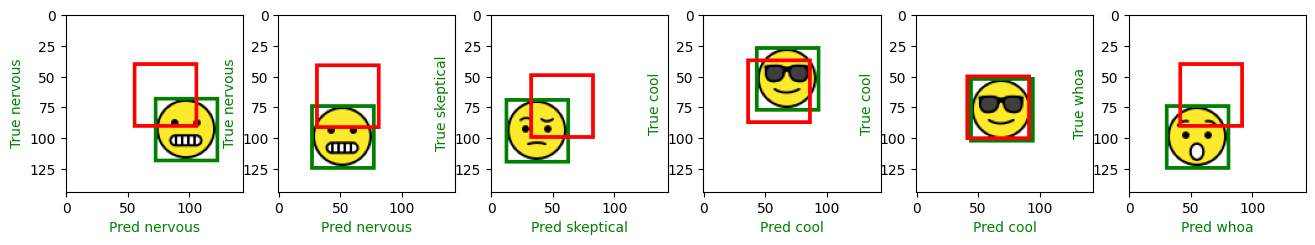

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 233ms/step - box_out_iou: 0.1818 - box_out_loss: 0.0034 - class_out_accuracy: 0.9990 - class_out_loss: 0.0033 - loss: 0.0067
Epoch 47/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - box_out_iou: 0.1639 - box_out_loss: 0.0045 - class_out_accuracy: 0.9960 - class_out_loss: 0.0182 - loss: 0.0227

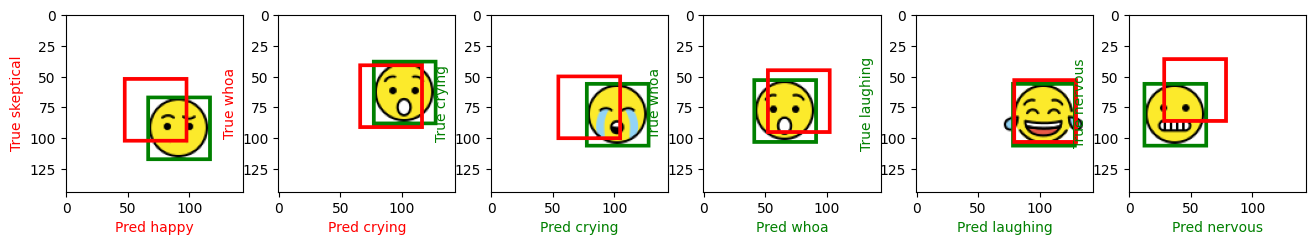

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - box_out_iou: 0.1639 - box_out_loss: 0.0045 - class_out_accuracy: 0.9960 - class_out_loss: 0.0182 - loss: 0.0227
Epoch 48/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - box_out_iou: 0.1495 - box_out_loss: 0.0088 - class_out_accuracy: 0.9923 - class_out_loss: 0.0295 - loss: 0.0383

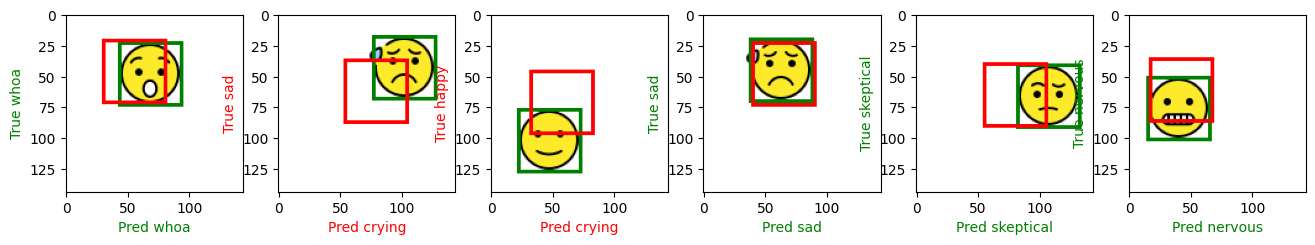

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 234ms/step - box_out_iou: 0.1495 - box_out_loss: 0.0088 - class_out_accuracy: 0.9923 - class_out_loss: 0.0295 - loss: 0.0383
Epoch 49/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - box_out_iou: 0.1777 - box_out_loss: 0.0029 - class_out_accuracy: 0.9995 - class_out_loss: 0.0021 - loss: 0.0050

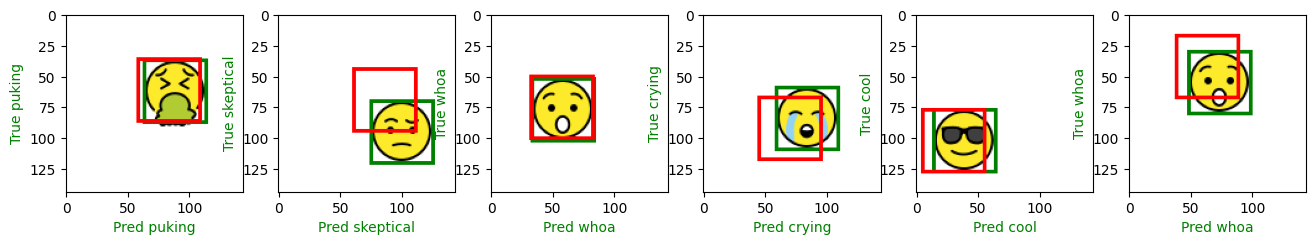

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - box_out_iou: 0.1777 - box_out_loss: 0.0029 - class_out_accuracy: 0.9995 - class_out_loss: 0.0021 - loss: 0.0050
Epoch 50/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - box_out_iou: 0.1800 - box_out_loss: 0.0023 - class_out_accuracy: 0.9994 - class_out_loss: 0.0022 - loss: 0.0045

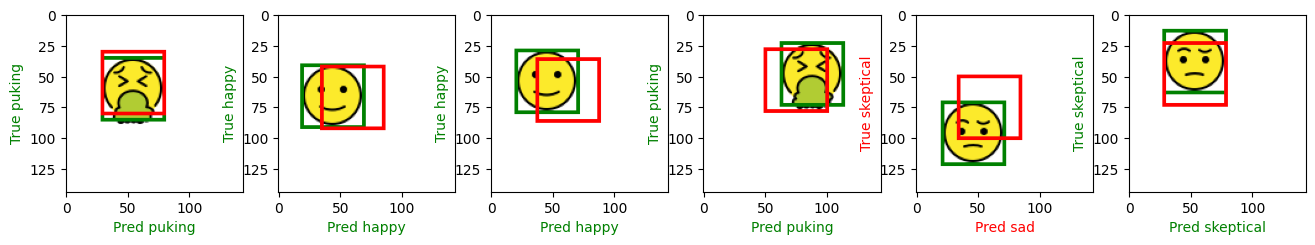

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 233ms/step - box_out_iou: 0.1801 - box_out_loss: 0.0023 - class_out_accuracy: 0.9994 - class_out_loss: 0.0022 - loss: 0.0045
Epoch 51/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - box_out_iou: 0.2022 - box_out_loss: 0.0019 - class_out_accuracy: 0.9990 - class_out_loss: 0.0022 - loss: 0.0041

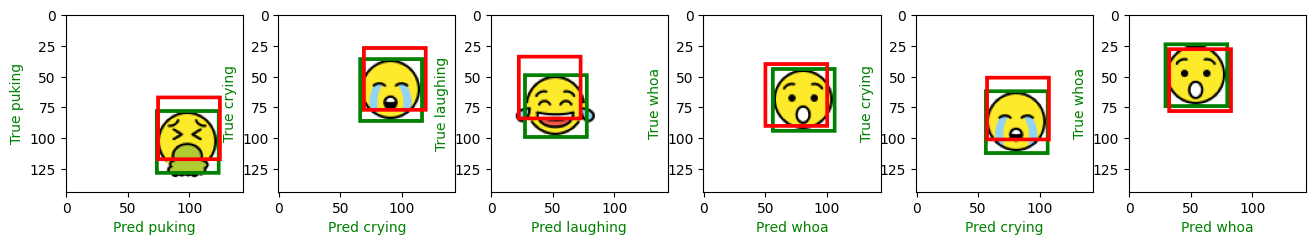

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - box_out_iou: 0.2022 - box_out_loss: 0.0019 - class_out_accuracy: 0.9990 - class_out_loss: 0.0022 - loss: 0.0041
Epoch 52/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - box_out_iou: 0.2063 - box_out_loss: 0.0020 - class_out_accuracy: 1.0000 - class_out_loss: 6.9468e-05 - loss: 0.0021

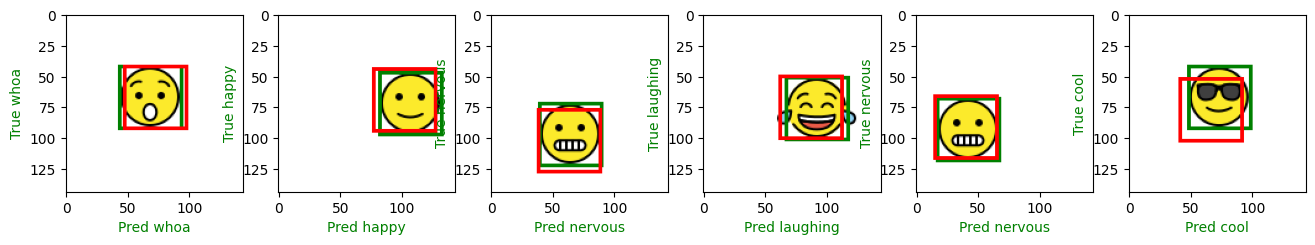

300/300 ━━━━━━━━━━━━━━━━━━━━ 71s 235ms/step - box_out_iou: 0.2063 - box_out_loss: 0.0020 - class_out_accuracy: 1.0000 - class_out_loss: 6.9436e-05 - loss: 0.0020
Epoch 53/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - box_out_iou: 0.2087 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - class_out_loss: 6.0452e-05 - loss: 0.0016

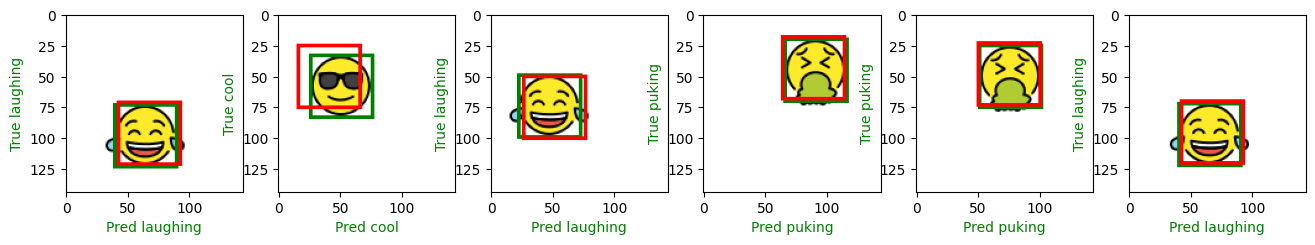

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - box_out_iou: 0.2086 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - class_out_loss: 6.0379e-05 - loss: 0.0016
Epoch 54/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - box_out_iou: 0.2167 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - class_out_loss: 1.3076e-04 - loss: 0.0016

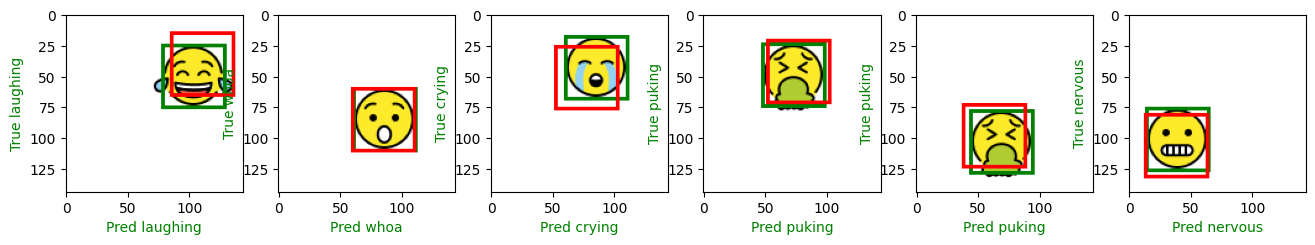

300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - box_out_iou: 0.2167 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - class_out_loss: 1.3107e-04 - loss: 0.0016
Epoch 55/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - box_out_iou: 0.2085 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - class_out_loss: 1.2597e-04 - loss: 0.0017

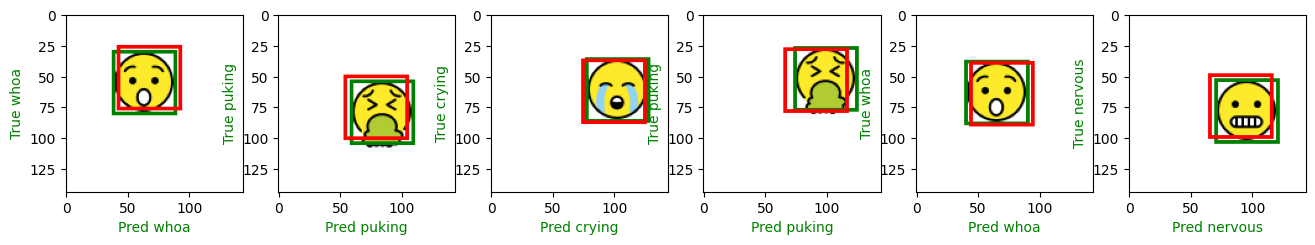

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - box_out_iou: 0.2085 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - class_out_loss: 1.2592e-04 - loss: 0.0017
Epoch 56/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - box_out_iou: 0.2047 - box_out_loss: 0.0017 - class_out_accuracy: 1.0000 - class_out_loss: 4.5553e-05 - loss: 0.0017

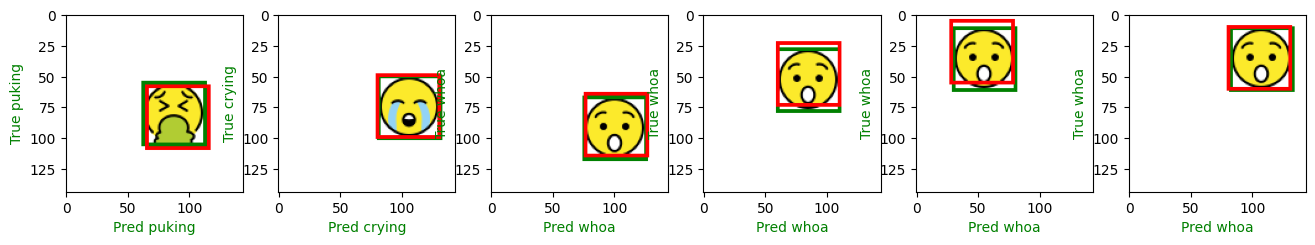

300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 239ms/step - box_out_iou: 0.2047 - box_out_loss: 0.0017 - class_out_accuracy: 1.0000 - class_out_loss: 4.5499e-05 - loss: 0.0017
Epoch 57/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - box_out_iou: 0.2105 - box_out_loss: 0.0017 - class_out_accuracy: 0.9988 - class_out_loss: 0.0042 - loss: 0.0059

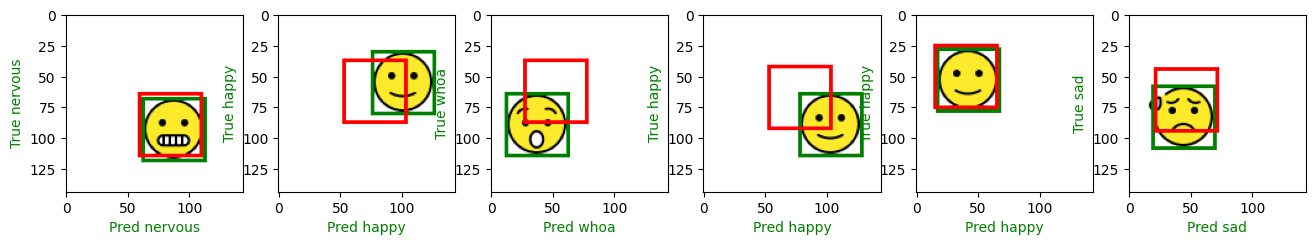

300/300 ━━━━━━━━━━━━━━━━━━━━ 71s 235ms/step - box_out_iou: 0.2104 - box_out_loss: 0.0017 - class_out_accuracy: 0.9988 - class_out_loss: 0.0042 - loss: 0.0059
Epoch 58/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - box_out_iou: 0.1947 - box_out_loss: 0.0020 - class_out_accuracy: 1.0000 - class_out_loss: 1.2847e-04 - loss: 0.0021

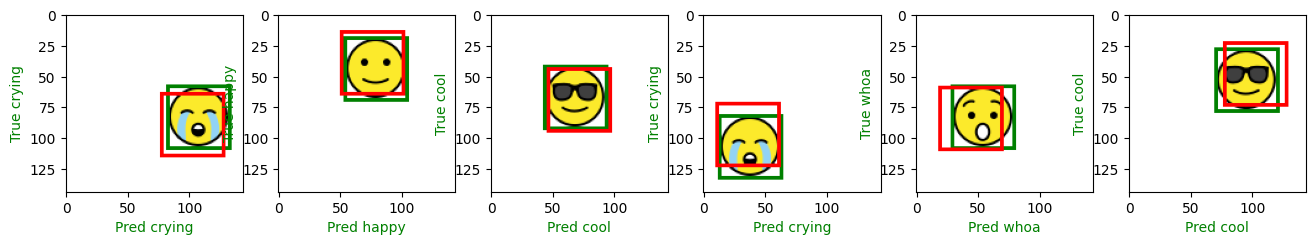

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 232ms/step - box_out_iou: 0.1947 - box_out_loss: 0.0020 - class_out_accuracy: 1.0000 - class_out_loss: 1.2839e-04 - loss: 0.0021
Epoch 59/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - box_out_iou: 0.2121 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - class_out_loss: 1.0492e-04 - loss: 0.0017

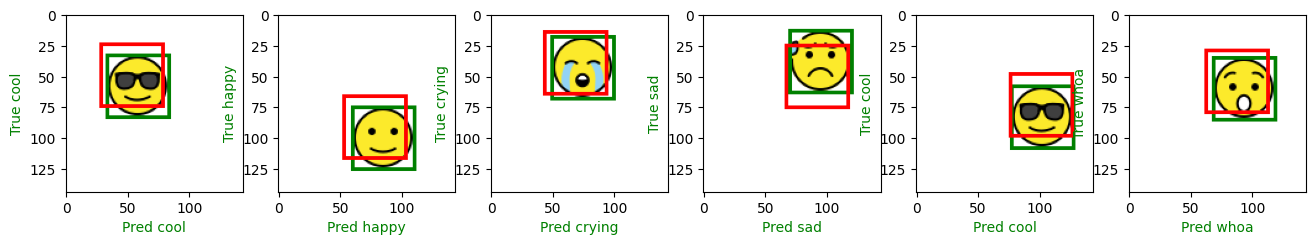

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 233ms/step - box_out_iou: 0.2121 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - class_out_loss: 1.0515e-04 - loss: 0.0017
Epoch 60/60
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - box_out_iou: 0.2142 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - class_out_loss: 2.9775e-05 - loss: 0.0016

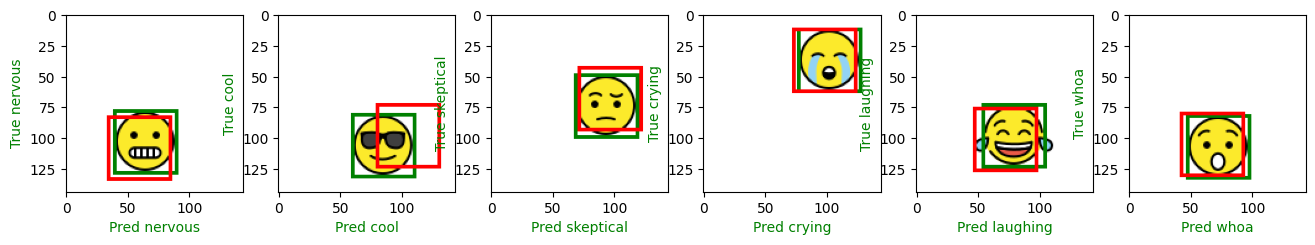

300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 233ms/step - box_out_iou: 0.2142 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - class_out_loss: 2.9771e-05 - loss: 0.0016


In [137]:
model.fit(data_generator(),
                    epochs=60,
                    steps_per_epoch=300,
                    callbacks = [imagegenerator()]
                    )

We see that model has gotten good at identifying emoji class as well as location, which was our goal.